In [15]:
import cv2 as cv
import numpy as np
import argparse
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib widget

W = 10          # window size is WxW
C_Thr = 0.92   # threshold for coherency
time_pixel_size = 0.1 #s.pixel
space_pixel_size = 0.267 #um.pixel
intensity_volume_factor = 1 #um**3.intensity-unit

def calcGST(inputIMG, w):
    img = inputIMG.astype(np.float32)
    imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0, 3)
    imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1, 3)
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w,w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w,w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w,w))
    tmp1 = J11 + J22
    tmp2 = J11 - J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0 * tmp3)
    lambda1 = 0.5*(tmp1 + tmp4)    # biggest eigenvalue
    lambda2 = 0.5*(tmp1 - tmp4)    # smallest eigenvalue
    imgCoherencyOut = cv.divide(lambda1 - lambda2, lambda1 + lambda2)
    imgOrientationOut = cv.phase(J22 - J11, 2.0 * J12, angleInDegrees = True)
    imgOrientationOut = 0.5 * imgOrientationOut
    return imgCoherencyOut, imgOrientationOut
path_fold = r'C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\JAAP\ExNo_110_Plate262_C2_NileRed_60x_T_KymographsWholeWidthRight'
paths = os.listdir(path_fold)
path = os.path.join(path_fold,paths[-5])
print(path)
imgIn = imageio.imread(path)
imgcrop = imgIn
imgCoherency, imgOrientation = calcGST(imgcrop, W)

C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\JAAP\ExNo_110_Plate262_C2_NileRed_60x_T_KymographsWholeWidthRight\220401_ExNo_110_60x_C2_Nile red_PLate262-T_13-26_01-AVG_kymo_2.tif


C:\Users\coren\AppData\Local\Temp\ipykernel_18788\1335729474.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)


In [79]:
path

'C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\DATA\\JAAP\\ExNo_110_Plate262_C2_NileRed_60x_T_KymographsWholeWidthRight\\220401_ExNo_110_60x_C2_Nile red_PLate262-T_11-35_01-2-AVG_kymo_2.tif'

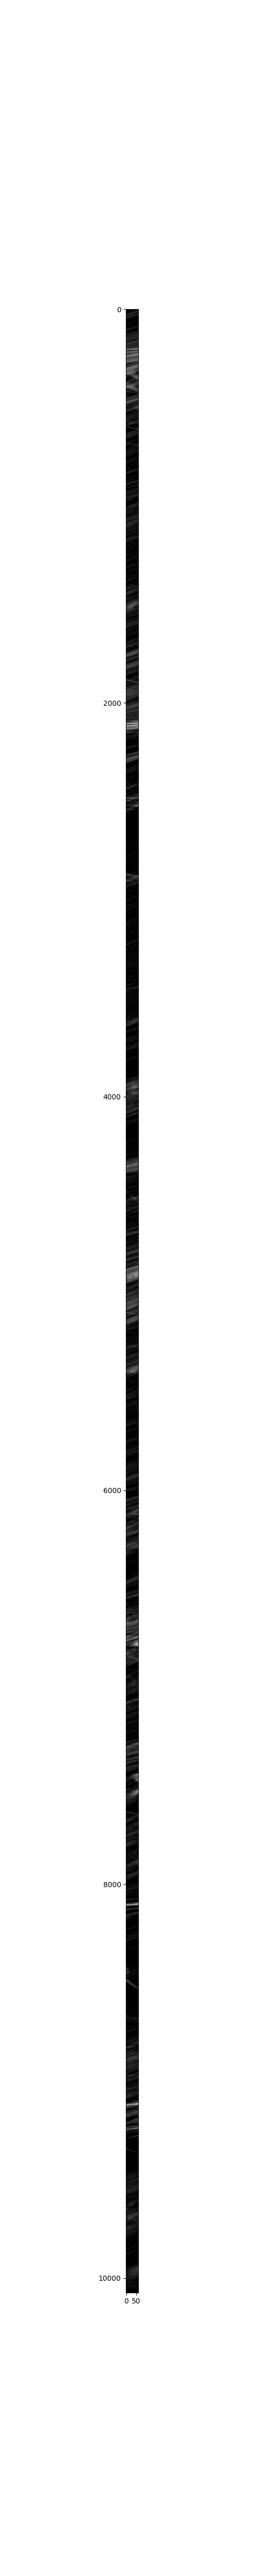

In [93]:
fig, ax = plt.subplots(figsize=(5,50))
ax.imshow(imgcrop,cmap="gray")

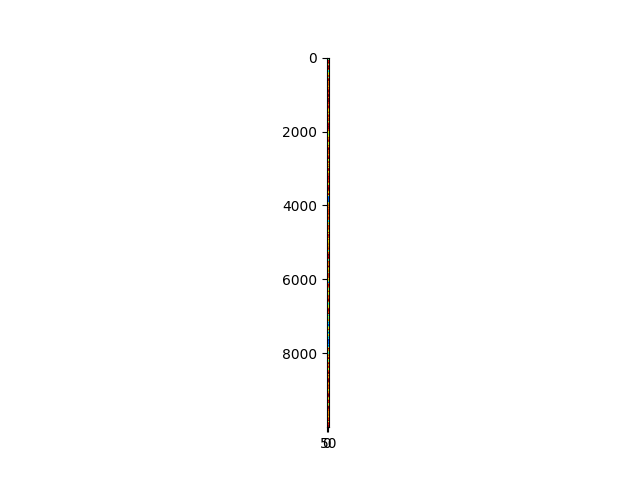

In [41]:
fig, ax = plt.subplots()
ax.imshow(imgCoherency,cmap="jet")

In [11]:
df = pd.DataFrame(columns=["filename", "time[s]", "speeds", "volume" "flux"])

nans = np.empty(imgOrientation.shape)
nans.fill(np.nan)
real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)
intensity = np.mean(imgcrop,axis=1) #um**3.um-1

speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
nans = np.empty(speeds.shape)
nans.fill(np.nan)
speeds = np.where(speeds<20,speeds,nans)
nans = np.empty(speeds.shape)
nans.fill(np.nan)
speeds = np.where(speeds>-20,speeds,nans)
nans = np.empty(speeds.shape)
nans.fill(np.nan)
speeds = np.where(intensity>4,speeds,nans)
df['speeds'] = speeds
df['filename'] = path.split("\\")[3][:-4]
df['time[s]'] = range(len(speeds))
df['time[s]']=df['time[s]']/10

C:\Users\coren\AppData\Local\Temp\ipykernel_18788\438728006.py:8: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1


array([[<AxesSubplot:title={'center':'speeds'}>]], dtype=object)

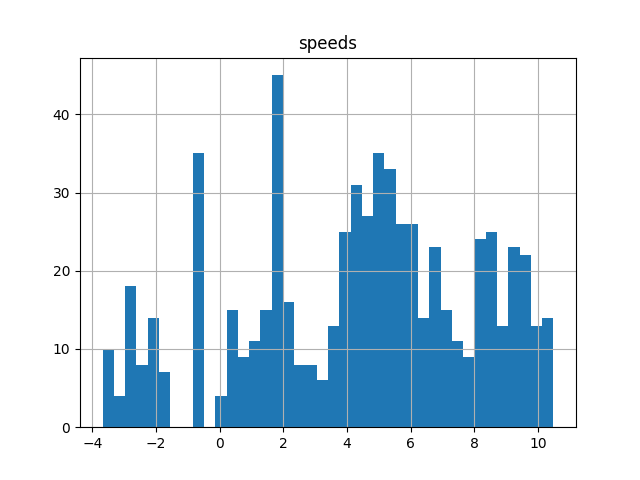

In [12]:
df.hist("speeds",bins= 40)

In [96]:
import numpy as np

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

y= speeds
nans, x= nan_helper(y)
y[nans]= np.interp(x(nans), x(~nans), y[~nans])
speeds=y

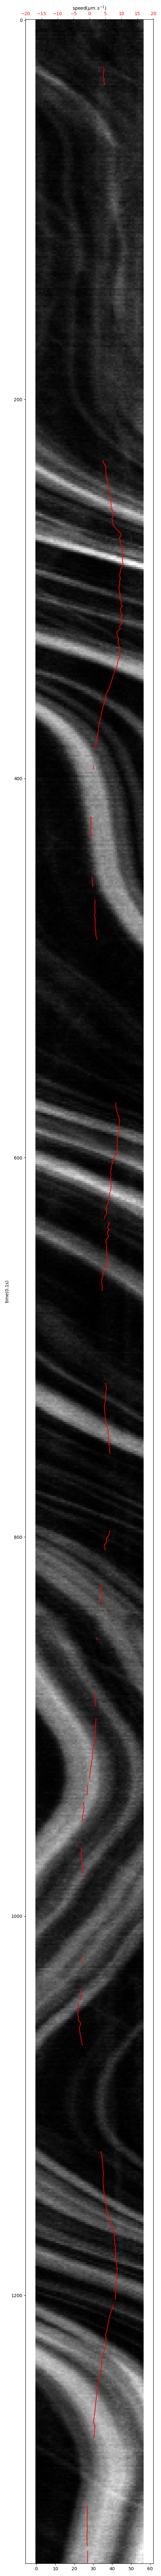

In [13]:
fig, ax = plt.subplots(figsize=(5,80))
ax.imshow(imgcrop,cmap="gray")
ax.set_ylabel('time(0.1s)')
ax2 = ax.twiny()
# ax2.plot(np.tan((np.mean(imgOrientation,axis=1)-90)/180*np.pi),range(len(np.mean(imgOrientation,axis=1))),color = "red")
# ax2.plot(speeds,np.array(range(len(speeds))),color = "red")
ax2.plot(df['speeds'],df['time[s]']*10,color = "red")

ax2.tick_params(axis='x', colors='red')
ax2.set_xlabel('speed($\mu m.s^{-1}$)')


# ax.imshow(imgOrientation*(imgCoherency>C_Thr),alpha=0.5,cmap="jet")
ax2.set_xlim((-20,20))

plt.tight_layout()

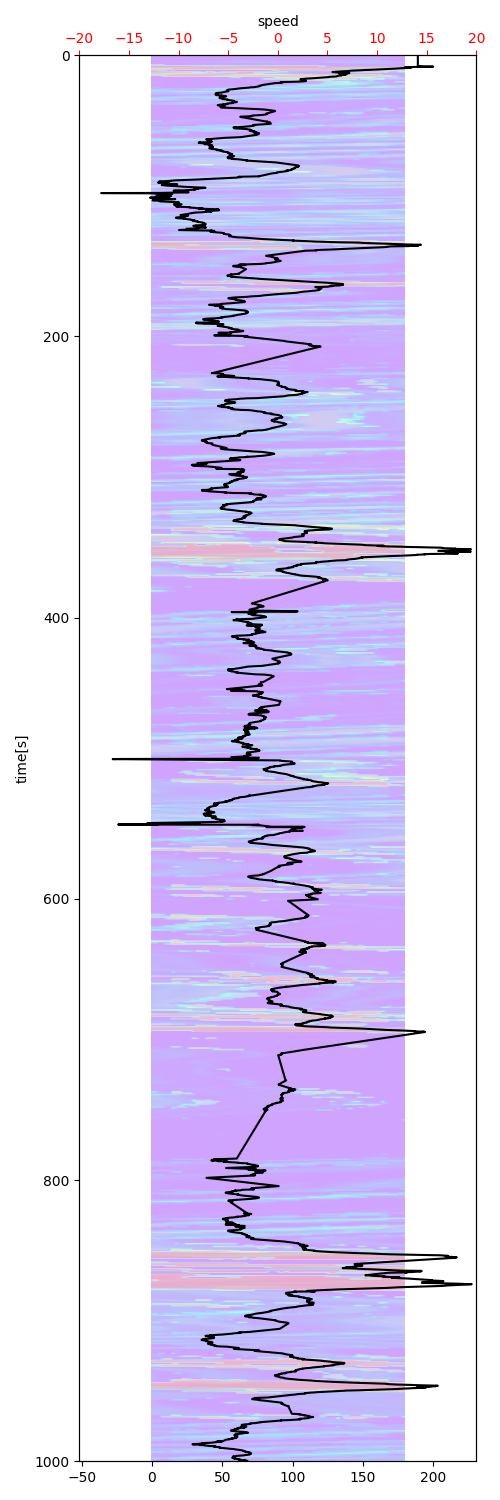

In [11]:
fig, ax = plt.subplots(figsize=(5,15))

ax2 = ax.twiny()
# ax2.plot(np.tan((np.mean(imgOrientation,axis=1)-90)/180*np.pi),range(len(np.mean(imgOrientation,axis=1))),color = "red")
ax2.plot(speeds,df['time[s]'],color = "black")

ax2.tick_params(axis='x', colors='red')
ax2.set_xlabel('speed')
ax.set_ylabel('time[s]')

imO=imgOrientation*(imgCoherency>C_Thr)
imOresize = cv.resize(imO, (180, 1000)) 
ax.imshow(imS,alpha=0.2, cmap="rainbow")
ax.imshow(imOresize,alpha=0.2, cmap="rainbow")
ax2.set_xlim((-20,20))
ax2.set_ylim((1000,0))

plt.tight_layout()

In [40]:
infinitesimal_volume = np.mean(imgcrop,axis=1)*intensity_volume_factor/space_pixel_size #um**3.um-1
df['volume'] = infinitesimal_volume

In [10]:
fig, ax = plt.subplots(figsize=(5,15))
imS = cv.resize(imgcrop, (180, 1000)) # resize image
ax.imshow(imS,cmap="gray")
ax2 = ax.twiny()
ax2.tick_params(axis='x', colors='red')
ax2.set_xlabel('volume')
ax.set_ylabel('time[s]')
# ax2.plot(np.tan((np.mean(imgOrientation,axis=1)-90)/180*np.pi),range(len(np.mean(imgOrientation,axis=1))),color = "red")
ax2.plot(infinitesimal_volume,df['time[s]'],color = "red")
ax2.set_ylim((1000,0))
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [41]:
flux = infinitesimal_volume*speeds #um**3.s-1
df['flux'] = flux

fig, ax = plt.subplots(figsize=(5,15))
imS = cv.resize(imgcrop, (180, 1000)) # resize image
ax.imshow(imS,cmap="gray")

ax2 = ax.twiny()
ax2.tick_params(axis='x', colors='red')
ax2.set_xlabel('flux')
ax.set_ylabel('time[s]')
# ax2.plot(np.tan((np.mean(imgOrientation,axis=1)-90)/180*np.pi),range(len(np.mean(imgOrientation,axis=1))),color = "red")
ax2.plot(flux,df['time[s]'],color = "red")
plt.tight_layout()
ax2.set_xlim((-8000,8000))
ax2.set_ylim((1000,0))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1000.0, 0.0)

In [12]:
# print("mean flux (um**3.s-1)", np.nanmean(flux),np.nanstd(flux)/np.sqrt(len(flux)/30))
print("mean speed (um.s-1)", np.nanmean(speeds),np.nanstd(speeds)/np.sqrt(len(speeds)/30))


mean speed (um.s-1) -0.6118862020901684 0.27568550599157826


In [15]:
from scipy.fft import fft, fftfreq

# Number of sample points
N = len(speeds)
x = np.linspace(0.0, N*time_pixel_size, N, endpoint=False)

y = (speeds-np.mean(speeds))/np.std(speeds)
yf = fft(y)
T = time_pixel_size
from scipy.signal import blackman

w = blackman(N)

ywf = fft(y*w)

xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')

# ax.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')

# ax.legend(['FFT', 'FFT w. window'])

ax.grid()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [16]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]
fig, ax = plt.subplots()
autoc = autocorr(y)
autoc = autoc/autoc.max()
lags = np.linspace(0.0, len(autoc)*time_pixel_size, len(autoc), endpoint=False)
ax.plot(lags,autoc, label = 'savgol filter')
ax.set_xlabel('lag (s)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'lag (s)')

In [17]:
fig, ax = plt.subplots()
autoc = autocorr(y)
autoc = autoc/autoc.max()
lags = np.linspace(0.0, len(autoc)*time_pixel_size, len(autoc), endpoint=False)
ax.plot(lags,autoc, label = 'savgol filter')
ax.set_xlabel('lag (s)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'lag (s)')

In [17]:
paths[:-3]

['220330_ExNo_110_60x_C2_Nile red_PLate262-T_15-50_0101_1-AVG_kymo2.tif',
 '220330_ExNo_110_60x_C2_Nile red_PLate262-T_15-50_0101_2-AVG_kymo2.tif',
 '220330_ExNo_110_60x_C2_Nile red_PLate262-T_15-50_0101_2_kymo_2.tif',
 '220330_ExNo_110_60x_C2_Nile red_PLate262-T_15-50_0102_1-AVG_kymo_2.tif',
 '220330_ExNo_110_60x_C2_Nile red_PLate262-T_15-50_0102_2-AVG_kymo_2.tif',
 '220330_ExNo_110_60x_C2_Nile red_PLate262-T_15-50_0103-AVG_kymo2.tif',
 '220331_ExNo_110_60x_C2_Nile red_PLate262-T_11-35_01-1-AVG_kymo_2.tif',
 '220331_ExNo_110_60x_C2_Nile red_PLate262-T_11-35_01-2-AVG_kymo_2.tif',
 '220331_ExNo_110_60x_C2_Nile red_PLate262-T_13-10_02-AVG_kymo_2.tif',
 '220401_ExNo_110_60x_C2_Nile red_PLate262-T_11-35_01-1-AVG_kymo_2.tif',
 '220401_ExNo_110_60x_C2_Nile red_PLate262-T_11-35_01-2-AVG_kymo_2.tif',
 '220401_ExNo_110_60x_C2_Nile red_PLate262-T_12-16_01-AVG_kymo_2.tif',
 '220401_ExNo_110_60x_C2_Nile red_PLate262-T_12-19_01-AVG_kymo_2.tif',
 '220401_ExNo_110_60x_C2_Nile red_PLate262-T_13-26_01-

In [3]:
imgIn.shape

(1342, 68)

C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of em

mean speed (um.s-1) -0.6118862020901684 0.27568550599157826
mean speed (um.s-1) 1.2175222996428963 0.2637933921803464


C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warni

mean speed (um.s-1) 1.2175222996428963 0.2637933921803464
mean speed (um.s-1) 0.7914594157132093 0.24344936240724868


C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warni

mean speed (um.s-1) 0.3637702389860504 0.2211230711171419
mean speed (um.s-1) 3.484829139896237 0.4879818048531536


C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1


mean speed (um.s-1) -1.3238389370759656 0.28460894087896804
mean speed (um.s-1) -0.7897005748548135 0.3680961718237706


C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)


mean speed (um.s-1) -5.495029642903799 0.2622159832392854
mean speed (um.s-1) -6.990798680882199 0.3730125425560053


C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warni

mean speed (um.s-1) -7.764799926769057 0.2837282182922633
mean speed (um.s-1) -5.978336491979212 0.8471938472382988


C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)


mean speed (um.s-1) -3.4303838080351814 0.6366178307533458


C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgIn = imageio.imread(path)
C:\Users\coren\AppData\Local\Temp\ipykernel_17264\3464129126.py:15: RuntimeWarning: Mean of empty slice
  speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1


mean speed (um.s-1) -8.535701732167135 0.20848335793304767
mean speed (um.s-1) 3.6303749148736757 0.48764458761713775


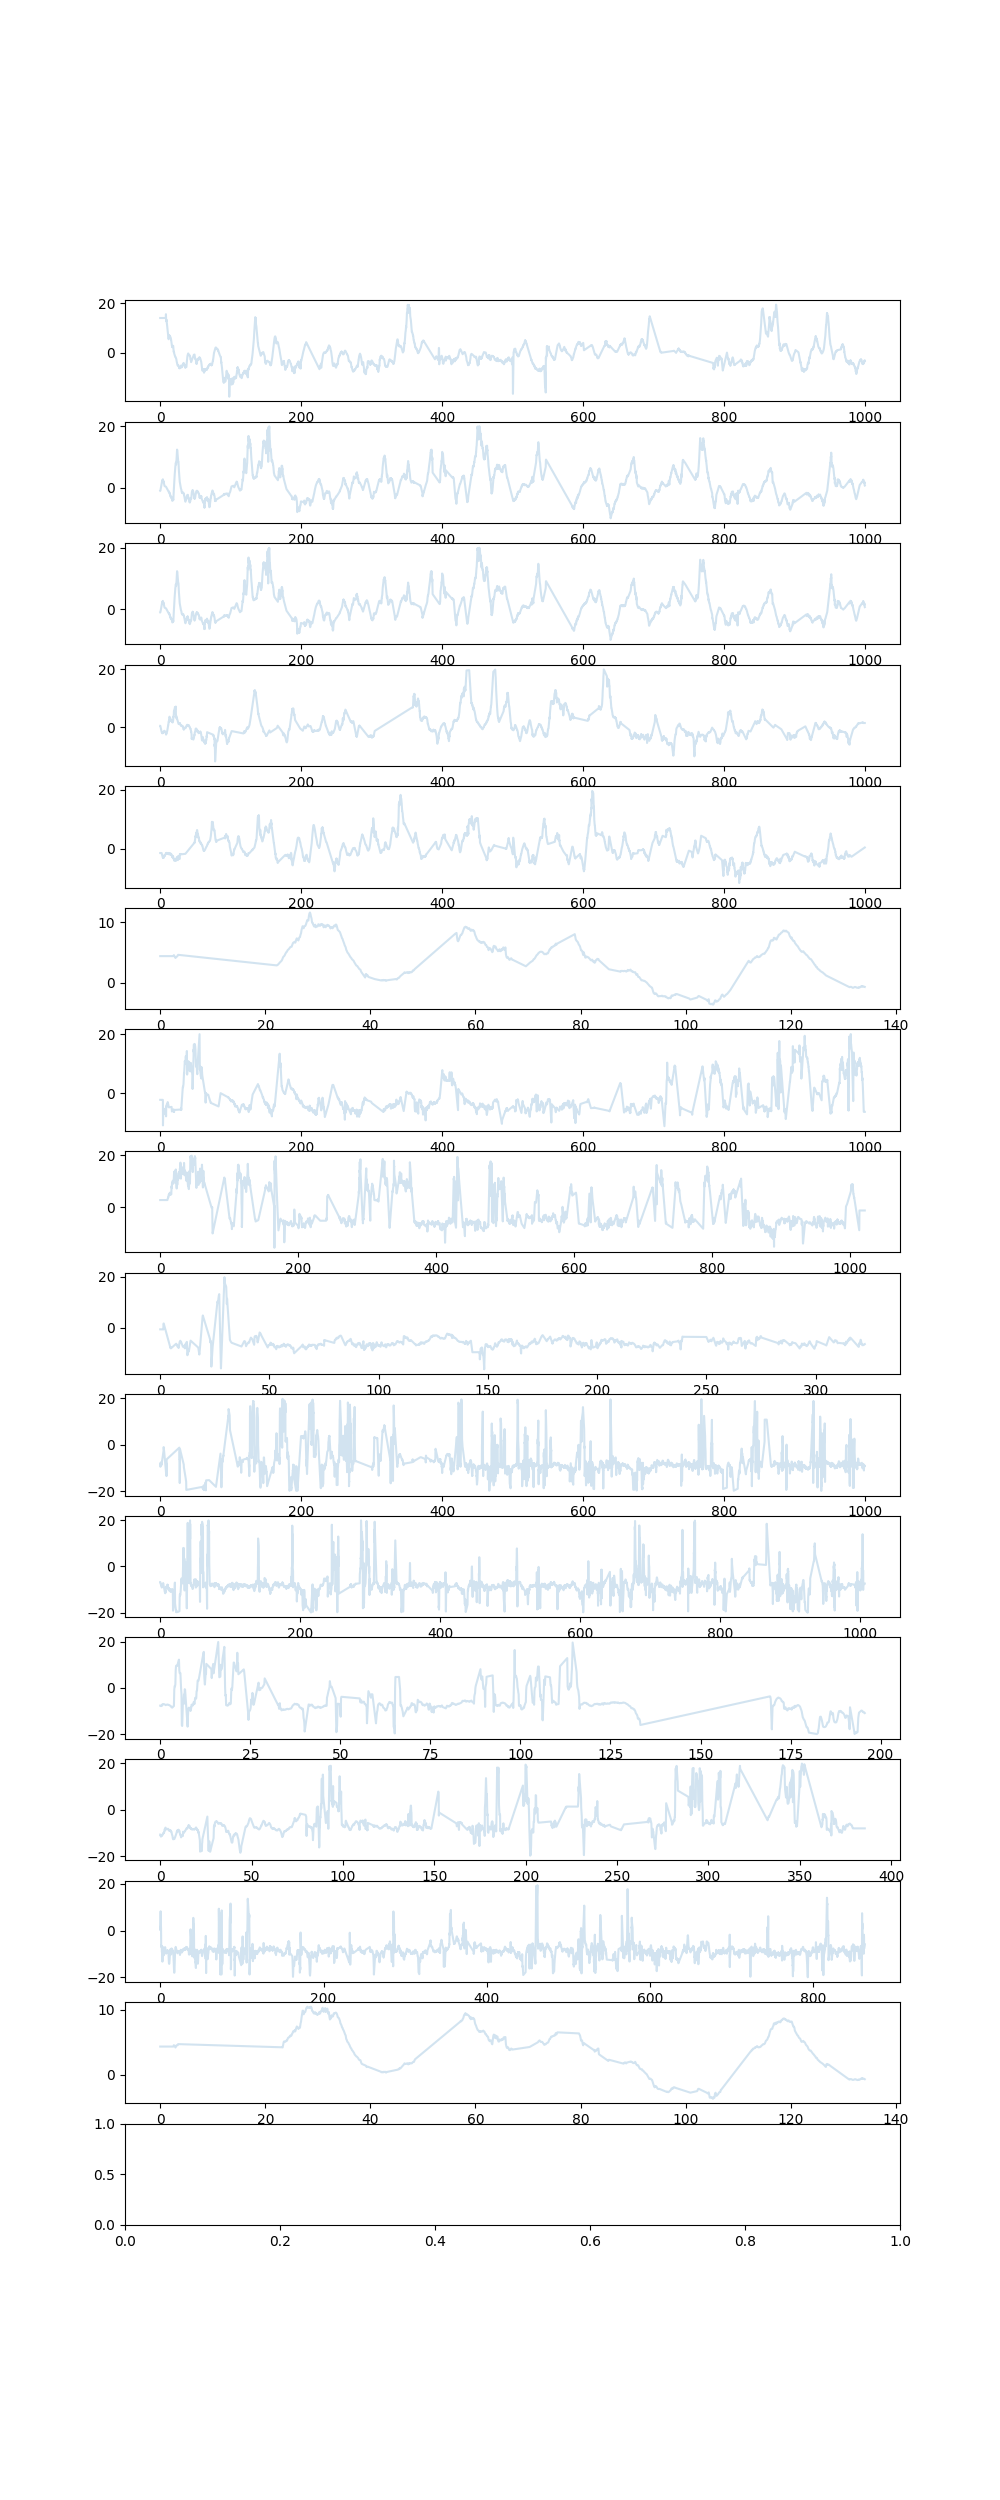

In [59]:
fig, axs = plt.subplots(16,figsize=(10,25))
# fig, ax = plt.subplots(figsize=(8,5))
df_total = pd.DataFrame()
for i,path in enumerate(paths[:-3]):
    path = os.path.join(path_fold,path)
    imgIn = imageio.imread(path)
    imgcrop = imgIn
    imgCoherency, imgOrientation = calcGST(imgcrop, W)
    df = pd.DataFrame(columns=["filename", "time[s]", "speeds", "volume" "flux"])
    nans = np.empty(imgOrientation.shape)
    nans.fill(np.nan)
    real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)
    intensity = np.mean(imgcrop,axis=1) #um**3.um-1

    speeds = np.tan((np.nanmean(real_movement,axis=1)-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
    nans = np.empty(speeds.shape)
    nans.fill(np.nan)
    speeds = np.where(speeds<20,speeds,nans)
    nans = np.empty(speeds.shape)
    nans.fill(np.nan)
    speeds = np.where(speeds>-20,speeds,nans)
    nans = np.empty(speeds.shape)
    nans.fill(np.nan)
    speeds = np.where(intensity>4,speeds,nans)
    df['speeds'] = speeds
    df['filename'] = path.split("\\")[-1][:-4]
    df['length'] = imgIn.shape[0] 
    df['time[s]'] = range(len(speeds))
    df['time[s]']=df['time[s]']/10
    y= speeds
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    speeds=y
    infinitesimal_volume = np.mean(imgcrop,axis=1)*intensity_volume_factor/space_pixel_size #um**3.um-1
    df['volume'] = infinitesimal_volume
    axs[i].plot(df['time[s]'],speeds,alpha = 0.2)
    df_total = pd.concat((df_total,df))
#     print("mean flux (um**3.s-1)", np.nanmean(flux),np.nanstd(flux)/np.sqrt(len(flux)/30))
    print("mean speed (um.s-1)", np.nanmean(speeds),np.nanstd(speeds)/np.sqrt(len(speeds)/30))
#     ax.plot(df['time[s]'],df['speeds'],alpha = 0.2)
    

array([[<AxesSubplot:title={'center':'speeds'}>]], dtype=object)

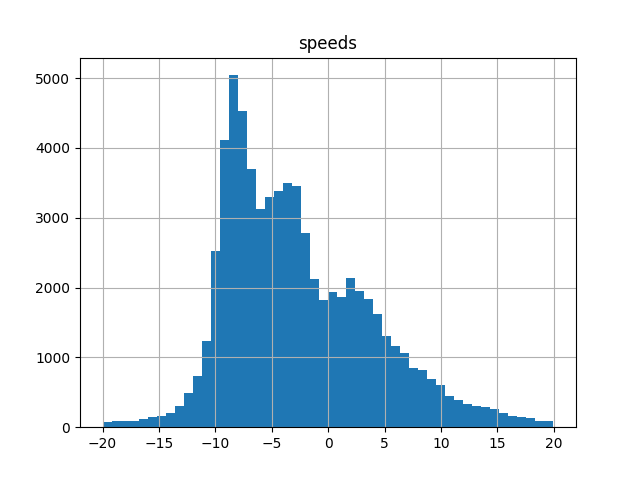

In [50]:
df_total.hist('speeds',bins= 50)

In [58]:
path.split("\\")[-1][:-4]

'220404_ExNo_110_60x_C2_Nile red_PLate262-T_11-44_01_kymo_2'

In [60]:
df_total['date'] = df_total['filename'].str[:6]


In [61]:
df_total['date']

0       220330
1       220330
2       220330
3       220330
4       220330
         ...  
1337    220404
1338    220404
1339    220404
1340    220404
1341    220404
Name: date, Length: 110639, dtype: object

(<Figure size 640x480 with 5 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

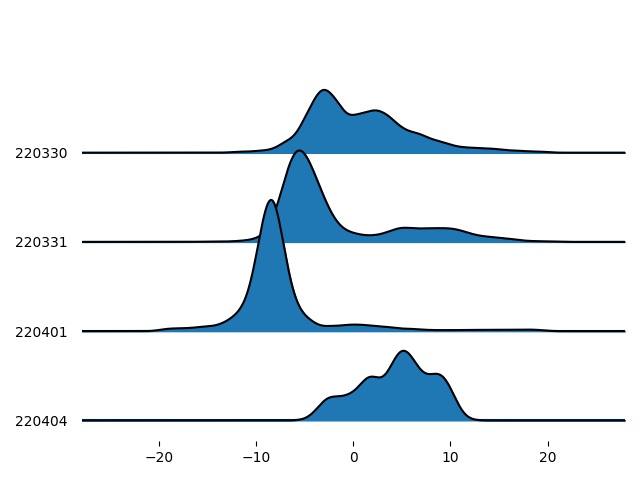

In [74]:
import joypy

joypy.joyplot(df_total,'speeds',by='date')


In [52]:
!pip install joypy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
N = len(autoc)
x = np.linspace(0.0, N*time_pixel_size, N, endpoint=False)

y = (speeds-np.mean(autoc))/np.std(autoc)
yf = fft(y)
T = time_pixel_size
from scipy.signal import blackman

w = blackman(N)

ywf = fft(y*w)

xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')

ax.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')

ax.legend(['FFT', 'FFT w. window'])

ax.grid()
